In [21]:
import sys
import os
import glob
import random
import copy
import math
from IPython.display import display, Markdown
sys.path.append('../..')

from matplotlib import pyplot as plt

from model.amm.stableswap_amm import StableSwapPoolState, simulate_swap
from model.amm.agents import Agent



In [22]:
def get_buy_params(
        facility_buffer: float,  # buffer represents the arb profit of buying from stableswap and selling to facility
        buy_amt_mult: float,  # how much of the stableswap's imbalance to make up in one block
        max_buy_price: float,  # minimum price at which facility buys Hollar
        pool: StableSwapPoolState
) -> tuple:
    buy_spot = pool.buy_spot(tkn_buy='HOL', tkn_sell='USDT')
    buy_price = buy_spot / (1 - facility_buffer)
    # buy quantity is difference in stableswap liquidity times buy_amt_mult
    imbalance = (pool.liquidity['HOL'] - pool.liquidity['USDT']) / 2
    if imbalance <= 0 or buy_spot > max_buy_price:
        buy_amt = 0
    else:
        buy_amt = imbalance * buy_amt_mult
    return buy_amt, buy_price



In [23]:
facility_liquidity = {'USDT': 1000000, 'HOL': 0}
hol_pct = 0.99
initial_tvl = 1000000
tokens = {'HOL': initial_tvl * hol_pct, 'USDT': initial_tvl * (1 - hol_pct)}

pool = StableSwapPoolState(tokens=tokens, amplification=1000, trade_fee=0.0001)
agent = Agent(holdings={'HOL': 0, 'USDT': 1000})
print("initial pool price:")
print(pool.buy_spot(tkn_buy='HOL', tkn_sell='USDT'))
buy_amts = []
buy_prices = []
buy_spots = []
for i in range(15000):
    buy_amt, buy_price = get_buy_params(facility_buffer=0.0001, buy_amt_mult=1/10000, max_buy_price=0.999, pool=pool)
    arb_buy_amt = buy_amt
    profit = 0
    for i in range(100):  # find profitable buy amount
        usdt_sell_amt = arb_buy_amt * buy_price
        new_pool, new_agent = simulate_swap(pool, agent, tkn_buy='HOL', tkn_sell='USDT', buy_quantity=arb_buy_amt)
        profit = usdt_sell_amt - (agent.holdings['USDT'] - new_agent.holdings['USDT'])
        if profit > 0:
            break
        else:
            arb_buy_amt /= 2
    if profit > 0:
        pool.swap(agent, tkn_buy='HOL', tkn_sell='USDT', buy_quantity=arb_buy_amt)  # buy HOL from stableswap
        facility_liquidity['HOL'] += arb_buy_amt  # receive buy_amt of HOL from agent
        agent.holdings['HOL'] -= arb_buy_amt  # sell buy_amt of HOL to facility
        facility_liquidity['USDT'] -= arb_buy_amt * buy_price  # pay USDT to agent
        agent.holdings['USDT'] += arb_buy_amt * buy_price  # receive USDT from facility
    buy_amts.append(buy_amt)
    buy_prices.append(buy_price)
    buy_spots.append(pool.buy_spot(tkn_buy='HOL', tkn_sell='USDT'))
print(pool.liquidity)
print('total Hollar bought off market: ' + str(facility_liquidity['HOL']))
print('total USDT paid by facility: ' + str(1000000 - facility_liquidity['USDT']))
print('arbitrager profits: ' + str(agent.holdings['USDT']))
print('average price paid by facility: ' + str((1000000 - facility_liquidity['USDT']) / facility_liquidity['HOL']))
print("final pool price: " + str(pool.buy_spot(tkn_buy='HOL', tkn_sell='USDT')))



initial pool price:
0.456279061451485
{'HOL': 688729.9004203933, 'USDT': 299696.3178658412}
total Hollar bought off market: 301270.0995795999
total USDT paid by facility: 289721.65353800275
arbitrager profits: 1025.3356721661821
average price paid by facility: 0.9616674669749432
final pool price: 0.9990001258240239


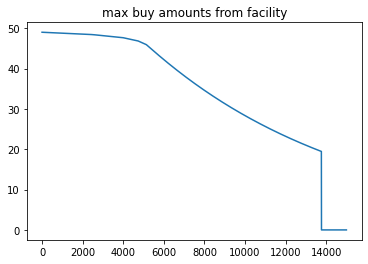

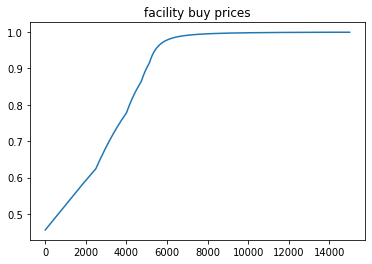

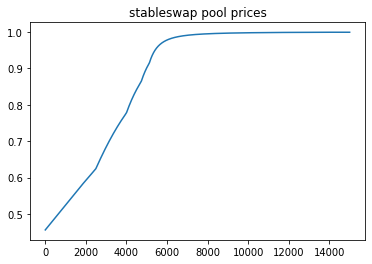

In [24]:
plt.plot(buy_amts)
plt.title("max buy amounts from facility")
plt.show()
plt.plot(buy_prices)
plt.title("facility buy prices")
plt.show()
plt.plot(buy_spots)
plt.title("stableswap pool prices")
plt.show()